In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_log_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
# 1. Load dataset
data = pd.read_csv('trainset.csv')  # Update this if needed
data.head()

,ID,Insurance_Coverage_Days,Insured_Age,Insured_Sex,Insured_Status,Insured_NoClaimYears,Insured_CreditScore,Insured_RegionID,Insured_DriveArea,Car_Use,...,Brake_06ms2_1000km,Brake_07ms2_1000km,LeftTurn_Low_1000km,LeftTurn_Med_1000km,LeftTurn_High_1000km,RightTurn_Low_1000km,RightTurn_Med_1000km,RightTurn_High_1000km,AMT_Claim,NB_Claim
0,1,349,57,Male,Married,31,843,73,Urban,Commute,...,1,1,495,84,1,1238,291,6,0.0,0
1,2,365,43,Male,Married,25,814,72,Urban,Commute,...,0,0,33,5,0,36,7,0,0.0,0
2,3,365,73,Male,Married,56,800,83,Rural,Private,...,0,0,30,5,0,103,17,0,0.0,0
3,4,366,66,Male,Married,48,752,87,Urban,Commute,...,0,0,9,1,0,13,2,0,0.0,0
4,5,218,71,Male,Married,48,858,86,Urban,Private,...,0,0,321,65,4,1157,391,33,0.0,0


**dato che non posso più submittare le cose, faccio qui train test split** 

In [3]:
# drop the ID
data.drop(columns="ID",inplace=True)

In [4]:
X = data.drop(columns="AMT_Claim")
y = data["AMT_Claim"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [5]:
X_train.shape

(40000, 45)

In [6]:
X_test.shape

(10000, 45)

## Cose che vorrei provare

1. Istogramma di ogni feature (plot mean and variance) -> if low variance drop the features... or just do PCA
2. Correlazioni di ogni feature con ogni altra
3. Binning continuous variables

4. What does random predictions give you? What does constant predictions give you?
5. Using transformers to create meaningful encodings.

#### Encode categorical variables

In [7]:
categorical_features = []
for key in X_train.keys():
    feature = X_train[key].iloc[0]
    if type(feature) == str:
        print(f"{key} unique values:",np.unique(X_train[key]))
        categorical_features.append((key,np.unique(X_train[key])))
        print("\n")
        

Insured_Sex unique values: ['Female' 'Male']


Insured_Status unique values: ['Married' 'Single']


Insured_DriveArea unique values: ['Rural' 'Urban']


Car_Use unique values: ['Commercial' 'Commute' 'Farmer' 'Private']




In [8]:
X_train["Sex"] = X_train["Insured_Sex"].map({"Female":1, "Male":0})
X_train["Status"] = X_train["Insured_Status"].map({"Married":1, "Single": 0})
X_train["Area"] = X_train["Insured_DriveArea"].map({"Rural":1, "Urban": 0})
X_train["Car"] = X_train["Car_Use"].map({"Commercial": 0,
                                         "Commute":1,
                                         "Farmer":2,
                                         "Private":3})

In [ ]:
# # female is 1, male is 0 
# X_train["Sex"] = [1 if sex=="Female" else 0 for sex in X_train["Insured_Sex"] ]
# X_train["Status"] =  [1 if status=="Married" else 0 for status in X_train["Insured_Status"] ]
# X_train["Area"] =  [1 if area=="Rural" else 0 for area in X_train["Insured_DriveArea"] ]
# X_train["Car"] = [
#     0 if car == categorical_features[-1][1][0] 
#     else 1 if car == categorical_features[-1][1][1] 
#     else 2 if car == categorical_features[-1][1][2] 
#     else 3
#     for car in X_train["Car_Use"]
# ]


In [9]:
# I can drop the old columns
X_train = X_train.drop(columns=["Insured_Sex","Insured_Status","Insured_DriveArea", "Car_Use"])

In [10]:
X_train.head()

,Insurance_Coverage_Days,Insured_Age,Insured_NoClaimYears,Insured_CreditScore,Insured_RegionID,Car_Age,AnnualDrive_km,TotDrive_km,Drive_Avgdays_week,Drive_TimeOnRoad_pct,...,LeftTurn_Med_1000km,LeftTurn_High_1000km,RightTurn_Low_1000km,RightTurn_Med_1000km,RightTurn_High_1000km,NB_Claim,Sex,Status,Area,Car
16397,184,59,43,813,87,11,10000,2606,4.9465,0.246575,...,24,0,306,49,1,0,0,1,1,3
41150,366,26,7,651,79,6,18000,10995,6.5856,0.482192,...,77,5,505,164,12,0,0,0,0,1
23962,365,67,50,821,24,8,10000,7353,3.6756,0.526027,...,7,0,888,377,40,0,0,1,1,0
20554,365,54,37,841,62,0,15000,1850,6.6067,0.202740,...,0,0,1,0,0,0,1,1,0,1
3829,365,52,33,703,83,8,15000,1734,6.1939,0.172603,...,17,0,280,49,1,0,1,1,0,1


### Histograms

array([[<Axes: title={'center': 'Insurance_Coverage_Days'}>,
        <Axes: title={'center': 'Insured_Age'}>,
        <Axes: title={'center': 'Insured_NoClaimYears'}>,
        <Axes: title={'center': 'Insured_CreditScore'}>,
        <Axes: title={'center': 'Insured_RegionID'}>,
        <Axes: title={'center': 'Car_Age'}>,
        <Axes: title={'center': 'AnnualDrive_km'}>],
       [<Axes: title={'center': 'TotDrive_km'}>,
        <Axes: title={'center': 'Drive_Avgdays_week'}>,
        <Axes: title={'center': 'Drive_TimeOnRoad_pct'}>,
        <Axes: title={'center': 'Drive_Mon_pct'}>,
        <Axes: title={'center': 'Drive_Tue_pct'}>,
        <Axes: title={'center': 'Drive_Wed_pct'}>,
        <Axes: title={'center': 'Drive_Thr_pct'}>],
       [<Axes: title={'center': 'Drive_Fri_pct'}>,
        <Axes: title={'center': 'Drive_Sat_pct'}>,
        <Axes: title={'center': 'Drive_Sun_pct'}>,
        <Axes: title={'center': 'Drive_2hrs_pct'}>,
        <Axes: title={'center': 'Drive_3hrs_pct'}>

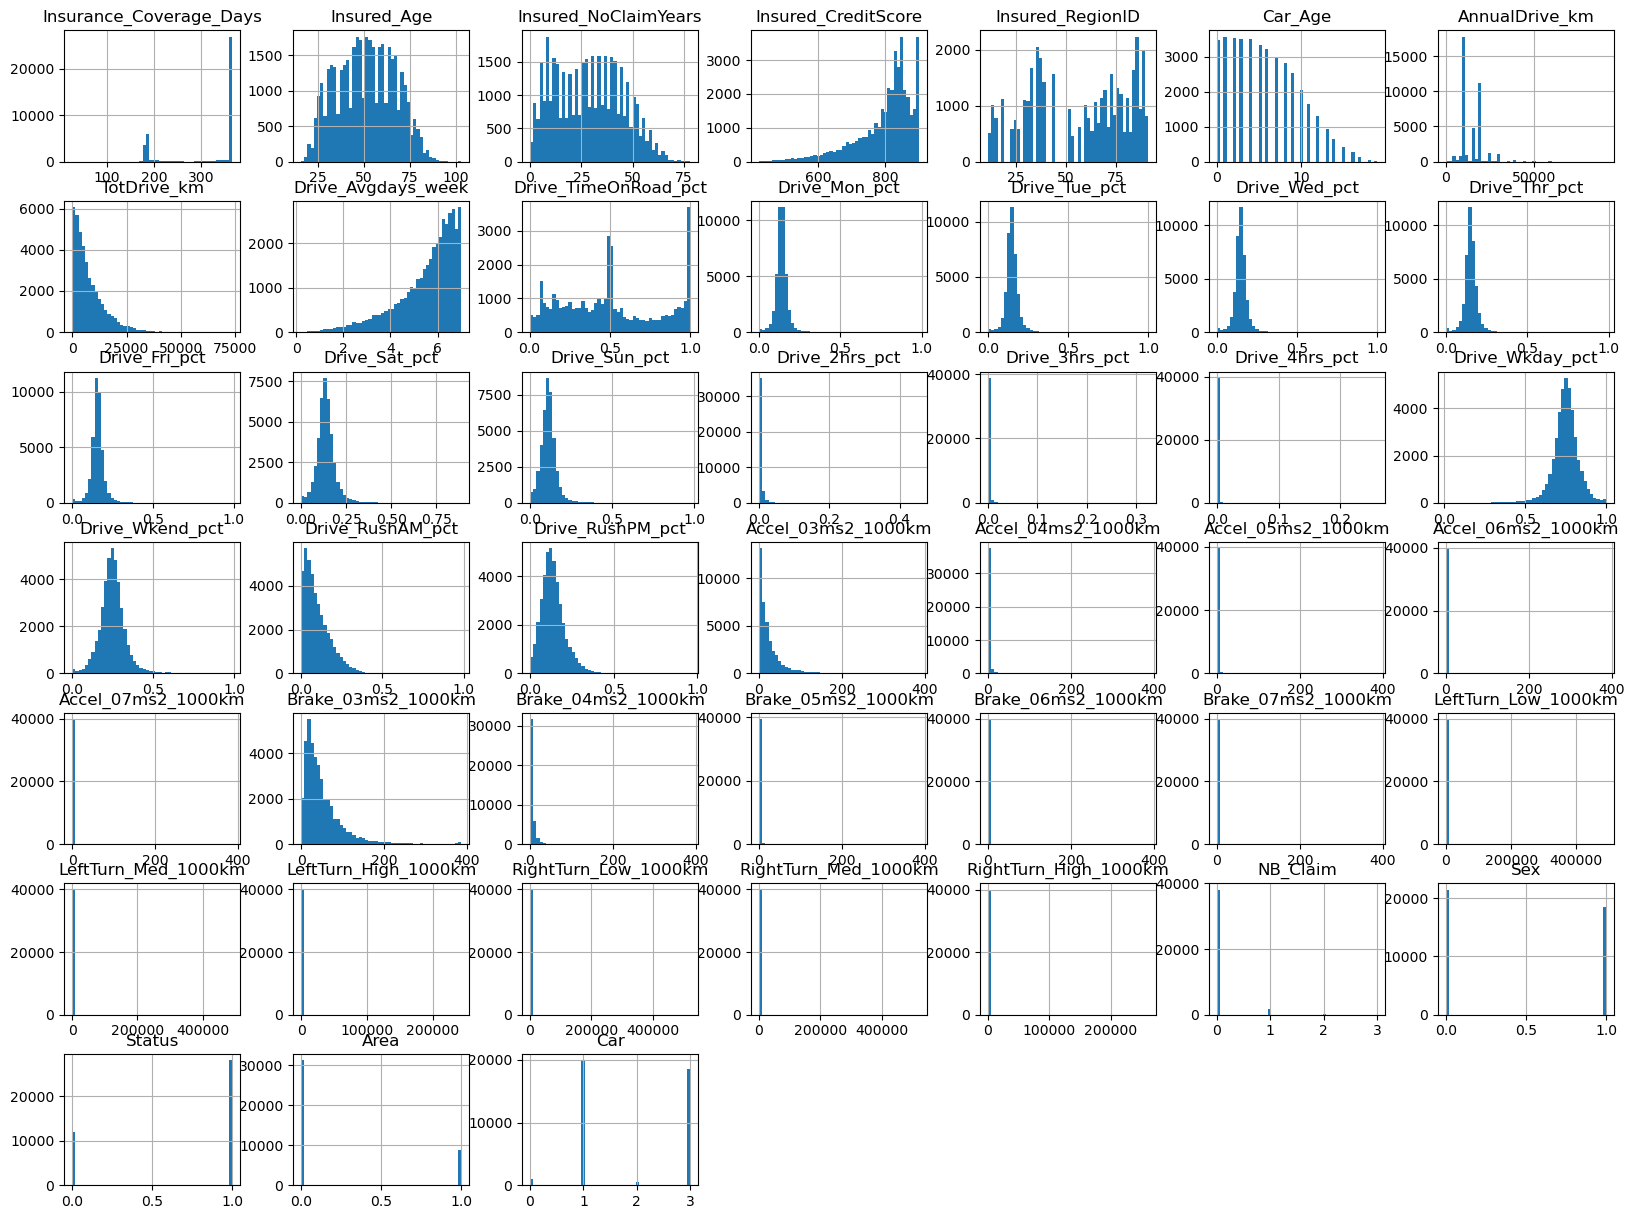

In [11]:
X_train.hist(figsize=(20, 15), bins=50)

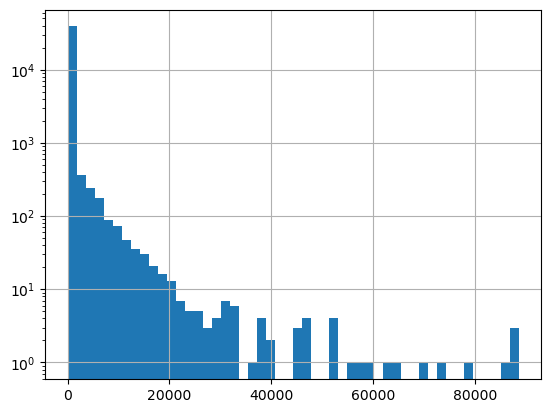

In [12]:
y_train.hist(bins=50)
plt.yscale('log')

Potrei scegliere a bunch of models e assessare le performance per ogni azione che svolgo sul dataset.

* Scelgo solo random forest perché altrimenti ho troppe robe da provare.

I test da svolgere sono: (sempre in cross validation)

- Mutual information

1. Random prediction (predicting random values)
2. Constant prediction
3. Performance of model without doing nothing

5. Applying log to ouptuts
6. Normalization of features
7. Binning
8. PCA (standardized, continuos variables, use it for feature selection maybe)
9. K-Means Clustering to add a new feature

## Study feature importance with mutual information

/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


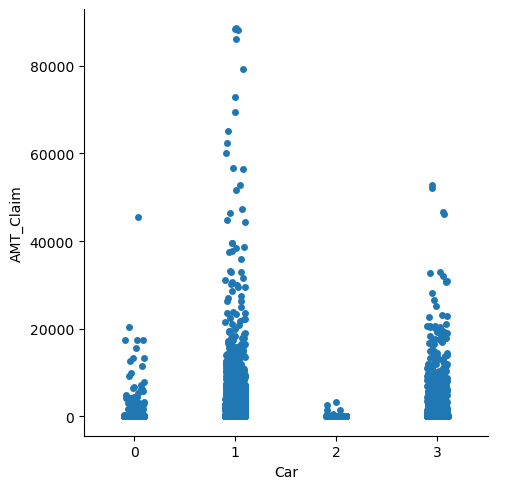

In [13]:
sns.catplot(pd.concat([X_train,y_train],axis=1),x="Car",y="AMT_Claim")
# "Commercial": 0,
# "Commute":1,
# "Farmer":2,
#  "Private":3})

In [14]:
mir = mutual_info_regression(X_train,y_train)

In [15]:
mir_scores = pd.Series(mir,name="MIR Scores",index=X_train.columns).sort_values(ascending=False)


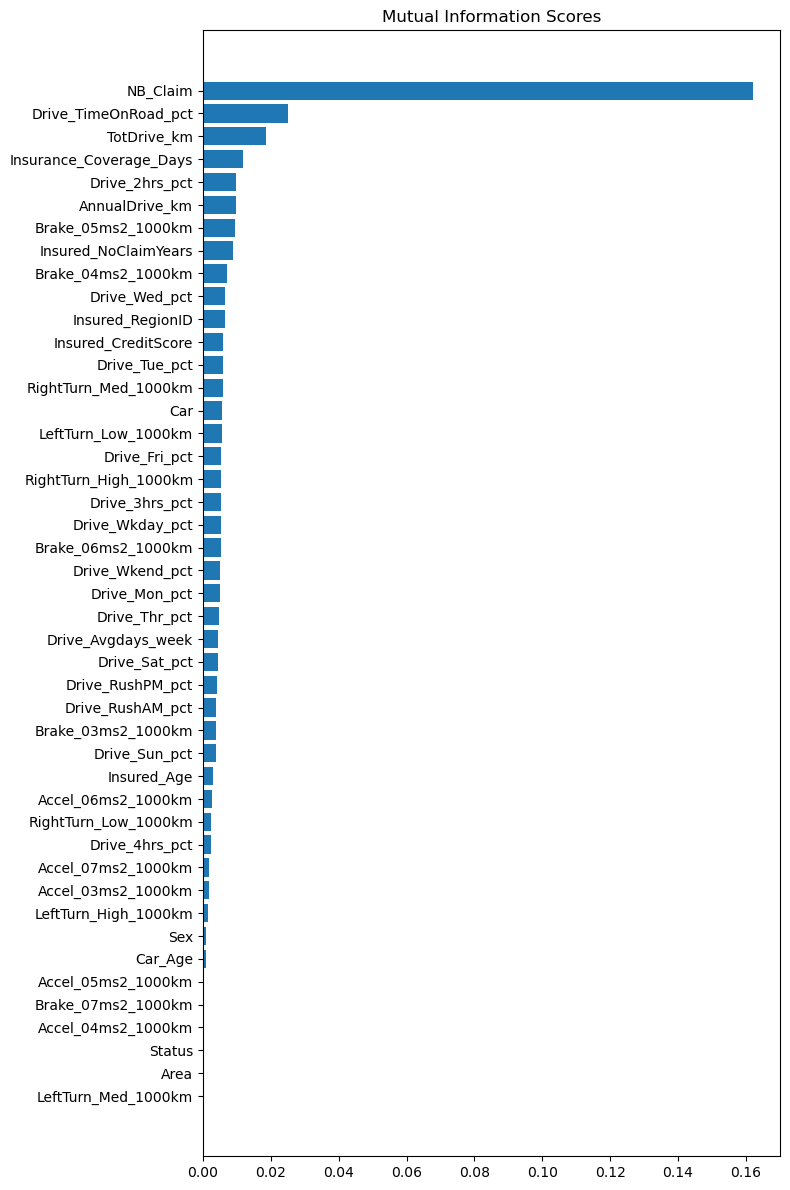

In [16]:
# Sort mutual information scores (descending order)
mir_scores_sorted = mir_scores.sort_values(ascending=True)  # ascending=True for barh (bottom=lowest, top=highest)

# Plot
plt.figure(figsize=(8, 12))  # width x height

width = np.arange(len(mir_scores_sorted))
ticks = list(mir_scores_sorted.index)

plt.barh(width, mir_scores_sorted)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

plt.tight_layout()
plt.show()


## Let's start with the baselines

### Random prediction model
Doing no data transformation whatsover (keeping y not log-transformed)

In [17]:
np.min(y_train), np.max(y_train)

(0.0, 88554.91)

In [18]:
def my_random_model(size=1):
    return np.random.random(size)*np.max(y_train)

In [ ]:
mean_squared_log_error(y_train,my_random_model(len(y_train)))

In [19]:
error = []
for maximum_value in np.linspace(0,np.max(y_train),100):
    error.append(mean_squared_log_error(y_train,np.random.random(len(y_train))*maximum_value))

Text(0, 0.5, 'MSLE')

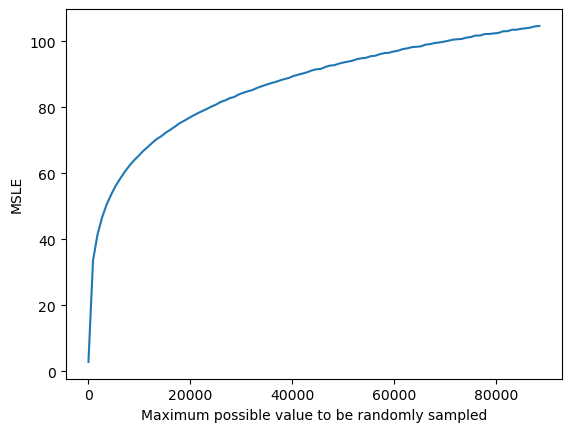

In [21]:
plt.plot(np.linspace(0,np.max(y_train),100),error)
plt.xlabel("Maximum possible value to be randomly sampled")
plt.ylabel("MSLE")

Let's try to zoom in.

I should take averages for each maximum value. This is a function of a random variable. You are interested in the expectations of MSLE fixing the maximum value. 

In [42]:
rand_error_zoom     = []
rand_error_zoom_std = []

for maximum_value in np.linspace(0,1.5,100):
    # iterate 100 times and take the average and std
    running_msle = []
    for _ in range(1000):
        running_msle.append(mean_squared_log_error(y_train,np.random.random(len(y_train))*maximum_value))
    
    rand_error_zoom.append(np.mean(running_msle))
    rand_error_zoom_std.append(np.std(running_msle))
    
    #rand_error_zoom.append(mean_squared_log_error(y_train,np.random.random(len(y_train))*maximum_value))


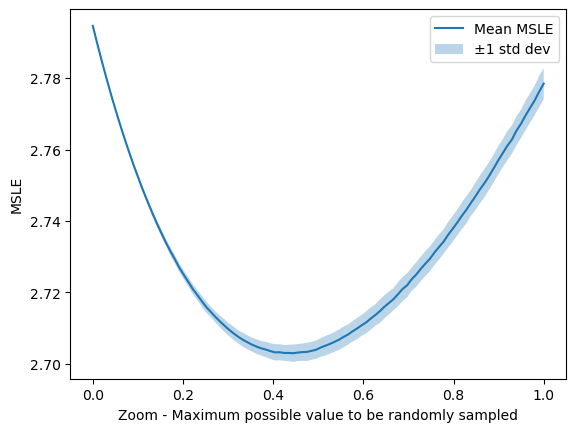

In [43]:
x = np.linspace(0, 1, 100)
y = np.array(rand_error_zoom)
yerr = np.array(rand_error_zoom_std)

plt.plot(x, y, label='Mean MSLE')
plt.fill_between(x, y - yerr, y + yerr, alpha=0.3, label='±1 std dev')
plt.xlabel("Zoom - Maximum possible value to be randomly sampled")
plt.ylabel("MSLE")
plt.legend()


What is it that we would like to minimize in this case? The mean value? The variance? Is there a formula to compute these?

### Constant prediction model

In [32]:
error_const = []
for constant_value in np.linspace(0,np.max(y_train),1000):
    error_const.append(mean_squared_log_error(y_train,np.array([constant_value for _ in y_train])))

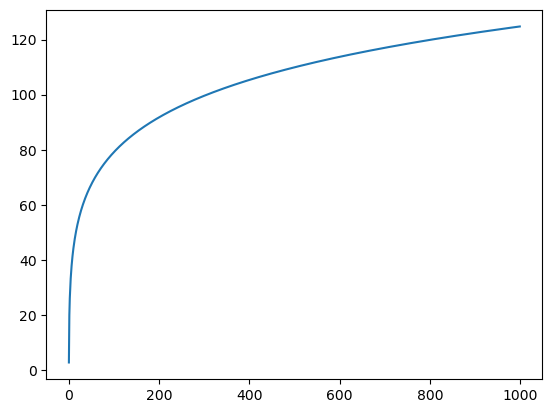

In [33]:
plt.plot(error_const)

In [34]:
closer_error = [mean_squared_log_error(y_train,np.array([constant_value for _ in y_train])) for constant_value in np.linspace(0,1,100)]

In [35]:
from scipy.optimize import minimize

In [36]:
def objective(y):
    return mean_squared_log_error(y_train,np.array([y for _ in range(len(y_train))]))

In [37]:
minimize(objective,x0=.5)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.677282138996734
        x: [ 4.085e-01]
      nit: 3
      jac: [ 6.169e-06]
 hess_inv: [[ 9.991e-01]]
     nfev: 8
     njev: 4

Text(0.2, 2.75, 'Min error obtained with \nconstant pred y=4.099e-01\n loss=2.687')

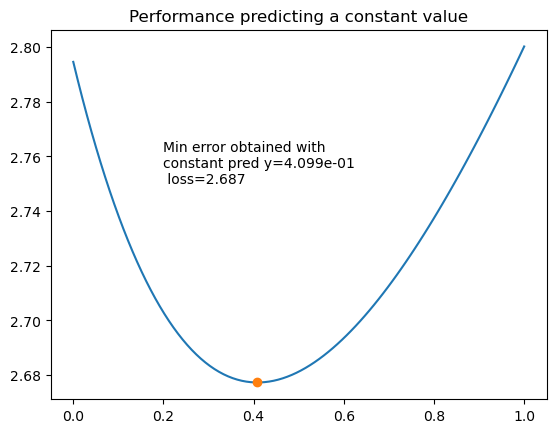

In [41]:
constant_values = np.linspace(0,1,100)
plt.plot(constant_values,closer_error)
plt.title("Performance predicting a constant value")
plt.plot(4.085e-01,2.677282138996734,"o")

plt.text(.2,2.75,f"Min error obtained with \nconstant pred y=4.099e-01\n loss=2.687")

I find that a naive model, predicting a constant value $y_{pred} = ~0.4$ achieves a loss of $l = ~2.687$.

This is the best naive baseline we want to defeat, using data science.

## Performance of model without doing nothing

In [70]:
rf = RandomForestRegressor(verbose=10,n_jobs=-1)
rf

RandomForestRegressor(n_jobs=-1, verbose=10)

In [62]:
scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1,verbose=4,scoring=make_scorer(mean_squared_log_error))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END .................................. score: (test=nan) total time=   0.3s
[CV] END .................................. score: (test=nan) total time=   0.3s
[CV] END .................................. score: (test=nan) total time=   0.3s
[CV] END .................................. score: (test=nan) total time=   0.3s
[CV] END .................................. score: (test=nan) total time=   0.0s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'absolute_error', 'friedman_mse', 'poisson'}. Got make_scorer(mean_squared_log_error) instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got make_scorer(mean_squared_log_error) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'poisson', 'squared_error', 'absolute_error'}. Got make_scorer(mean_squared_log_error) instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/Users/diego/miniconda3/envs/sir/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'poisson', 'absolute_error', 'friedman_mse'}. Got make_scorer(mean_squared_log_error) instead.


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.35 accuracy with a standard deviation of 0.04


This is NOT a trained model. It's needed for model selection (I think). Then, one should fit the actual random forest to have a trained model.

Let's try other models.

- GradientBoosting cannot be used together with MSLE for it produces negative outputs. I'd need to pre-process the data, which is something I'm planning to do in the next steps. 
- SVR is normalization dependent. This also implies that I will finetune it later (possibily with NNs too)


In [66]:
models = {
    #'RandomForest': RandomForestRegressor(),
    #'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train,
                             scoring=make_scorer(mean_squared_log_error),
                             cv=5, n_jobs=-1, verbose=0)
    print(f"{name} - RMSLE: {scores.mean():.4f} ± {scores.std():.4f}")


SVR - RMSLE: 2.7364 ± 0.1098


I found that RandomForest is the easiest model to train and it gives very good performance compared to the naive baseline. Let's see the performance on the whole train set.

In [71]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100

building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100building tree 58 of 100

building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.2s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.4s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.6s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.2s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished


RandomForestRegressor(n_jobs=-1, verbose=10)

In [72]:
y_pred = rf.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [73]:
mean_squared_log_error(y_train,y_pred)

0.24032819727010937

The performance of the RandomForest on the train set is 0.24 vs. 2.68 of the constant model.

Mi mancano:

5. Applying log to ouptuts
6. Normalization of features -> GradientBoosting, SVM, NN
7. Binning
8. PCA (standardized, continuos variables, use it for feature selection maybe)
8. Use MRI in some way??
9. K-Means Clustering to add a new feature